# The Simpsons Characters Image Classification
### By Fahmi Jabbar (fahmijabbar12@gmail.com)
---
**Disclaimer :** 
- Any code below is done by purposed to complete *Dicoding* Submission and made 100% by myself

---
**Dataset Information** : 

![Dataset Information](https://image.prntscr.com/image/_qCeUpWfSuSnB0Wxp4ZehA.png)

Link : https://www.kaggle.com/alexattia/the-simpsons-characters-dataset

## Data Preparation

### Import Important Library

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, random, time
import pandas as pd
import numpy as np
import tensorflow as tf

### Download Dataset

In [2]:
os.environ['KAGGLE_USERNAME'] = "fahmijabbar"
os.environ['KAGGLE_KEY'] = "70e97bf263ab4ed3b437c10c73941268"

In [3]:
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

100% 1.07G/1.08G [00:18<00:00, 28.8MB/s]
100% 1.08G/1.08G [00:18<00:00, 61.5MB/s]


### Unzip Dataset

In [4]:
!unzip -q /content/the-simpsons-characters-dataset.zip

In [5]:
# Remove duplicate dataset in subfolder
!rm -rf /content/simpsons_dataset/simpsons_dataset

## Dataset Information (Visualized)

In [84]:
base_dir = '/content/simpsons_dataset/'
labels = os.listdir(base_dir)
countedlabel = []

In [85]:
# Count total images each classes
file_count = []
for label in labels:
  dir = base_dir + label
  path, dirs, files = next(os.walk(dir))
  file_count.append(len(files))
print("Consist of " + str(len(file_count)) + " Classes")

# Count total images
total = 0
for num in file_count:
  total += num
print("And " + str(total) + " Total Images")

# Append total image in classes
x = 0
while x < len(labels):
  countedlabel.append(labels[x] + " (" + str(file_count[x]) + ")")
  x += 1

Consist of 42 Classes
And 20933 Total Images


### Plot Dataset Information Each Class

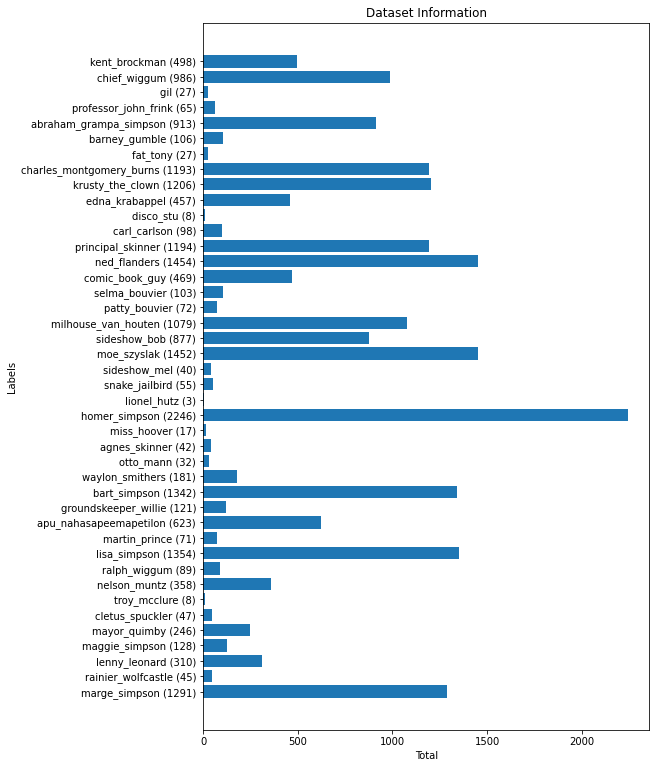

In [86]:
plt.figure(figsize=(8,13))
plt.barh(np.arange(len(labels)), file_count)
plt.yticks(np.arange(len(labels)), countedlabel)
plt.title('Dataset Information')
plt.xlabel('Total')
plt.ylabel('Labels')
plt.show()

### Prove Dataset Have Various Resolution

In [87]:
# Showing that each images have different resolution
def showRandom():
  pathx = base_dir + random.choice(labels) + "/"
  random_filename = random.choice([
    x for x in os.listdir(pathx)
    if os.path.isfile(os.path.join(path, x))
  ])
  return pathx+random_filename

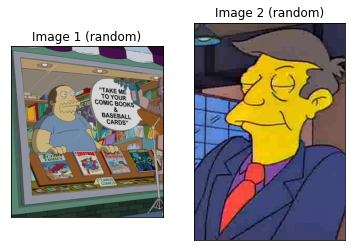

In [88]:
# Showing different resolution of images

fig = plt.figure()
img = mpimg.imread(showRandom())
ax = fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
ax.set_title('Image 1 (random)')
img = mpimg.imread(showRandom())
ax = fig.add_subplot(1, 2, 2)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
ax.set_title('Image 2 (random)')
plt.show()

## Image Augmentation

In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, #Normalization
    horizontal_flip=True, #Flip horizontally
    validation_split = 0.2 #Split data 80% train 20% val
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, #Normalization
    validation_split = 0.2 #Split data 80% train 20% val
)

In [12]:
img_shape = (224, 224, 3) #Based on resnet recommendation
train_generator = train_datagen.flow_from_directory(
    base_dir,
    shuffle=True,
    target_size= img_shape[:2],
    class_mode='categorical',
    batch_size=100,
    subset='training')

validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    shuffle=True,
    target_size= img_shape[:2],
    class_mode='categorical',
    batch_size=10,
    subset='validation')

Found 16764 images belonging to 42 classes.
Found 4169 images belonging to 42 classes.


## Download Pre-Trained Model (ResNet50V2)

In [13]:
base_model = tf.keras.applications.ResNet50V2(input_shape=img_shape, include_top=False)

94674944/94668760 [==============================] - 1s 0us/step


## Model Architecture

In [14]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
                                    base_model,
                                    tf.keras.layers.Conv2D(16, (4,4), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    # Using simple model because i use pre-trained model (transfer learning)
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(16, activation='relu'),
                                    tf.keras.layers.Dense(42, activation='softmax')])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 16)          524304    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 42)                714       
Total params: 24,090,858
Trainable params: 24,045,418
Non-trainable params: 45,440
_______________________________________

## Callback Function

In [16]:
#Tensorboard
!rm -rf /content/logs
log_dir="/content/logs/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#Custom Callback
class stopTraining(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') >= 0.92):
      print("\n\nReached Accuracy 92% & Val Accuracy 92%, Training stoped\n")
      self.model.stop_training = True

custom_callback = stopTraining()

#Model Checkpoint Callback
!rm -rf /content/model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/model/',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

## Training Model

In [18]:
with tf.device('/device:GPU:0'):
  model.fit(train_generator, 
            epochs = 100, 
            steps_per_epoch = 50,
            validation_data = validation_generator, 
            verbose = 1,
            validation_steps= 10,
            callbacks=[checkpoint_callback, tensorboard_callback, custom_callback])

Epoch 1/100
 1/50 [..............................] - ETA: 0s - loss: 5.2315 - accuracy: 0.0500WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
50/50 [==============================] - ETA: 0s - loss: 3.4471 - accuracy: 0.1082
Epoch 00001: val_accuracy improved from -inf to 0.14000, saving model to /content/model/
50/50 [==============================] - 48s 952ms/step - loss: 3.4471 - accuracy: 0.1082 - val_loss: 5.5998 - val_accuracy: 0.1400
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 2.4142 - accuracy: 0.3644
Epoch 00002: val_accuracy improved from 0.14000 to 0.20000, saving model to /content/model/
50/50 [==============================] - 48s 955ms/step - loss: 2.4142 - accuracy: 0.3644 - val_loss: 8.4165 - val_accuracy: 0.2000
Epoch

## Model Evaluation

### Plot accuracy & loss on tensorboard

In [19]:
!tensorboard dev upload --logdir /content/logs \
  --name "The Simpson Characters Image Classification" \
  --description "Dicoding Submission 3 - Image Classification. Model made by Fahmi Jabbar" \
  --one_shot

2020-08-22 10:59:35.198480: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Ao

In [ ]:
#For accuracy & loss model
#Please visit https://tensorboard.dev/experiment/xpDIerQFRUWzgpXngzkTJg/

Some screenshoot if the website is no more available

Model Accuracy

![Accuracy](https://image.prntscr.com/image/Y5LSDVUdRsyHBssuVwjkmg.png)

Model Loss

![Accuracy](https://image.prntscr.com/image/X7A3p59XQVaeo7MNGNkAaA.png)


## Model Prediction/Usage

/content/kaggle_simpson_testset/kaggle_simpson_testset/chief_wiggum_10.jpg
Predicted as = ralph_wiggum


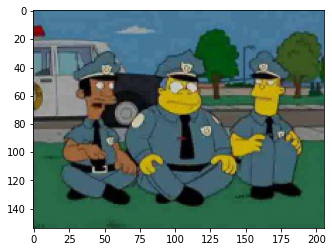

In [80]:
# From random test set image
test_set = '/content/kaggle_simpson_testset/kaggle_simpson_testset/'
choose_file = os.listdir(test_set)
choose_file = random.choice(choose_file)
path = test_set+choose_file
img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
plt.imshow(mpimg.imread(path))
print(test_set+choose_file)
print("Predicted as = " + labels[np.argmax(classes)])

Saving principal_skinner_5.jpg to principal_skinner_5 (2).jpg
Predicted as = principal_skinner


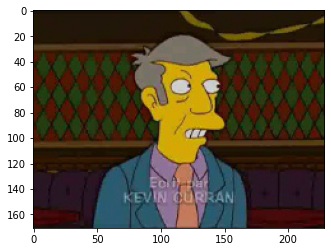

In [29]:
# From Uploaded Images (Choosen test set image)
from google.colab import files
uploaded = files.upload()

for gambar in uploaded.keys():
 
  path = gambar
  img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
  x = tf.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  plt.imshow(mpimg.imread(path))
  print("Predicted as = " + labels[np.argmax(classes)])

## Save Model

In [89]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpchdlik5f/assets


In [90]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [92]:
files.download('/content/model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>